In [1]:
import sys
sys.path.append('../')

import numpy as np
import pygme

%load_ext autoreload
%autoreload 2

from pygme import GuidedModeExp, Circle, PhotCryst, Lattice
import matplotlib.pyplot as plt
from itertools import zip_longest

## W1 waveguide supercell

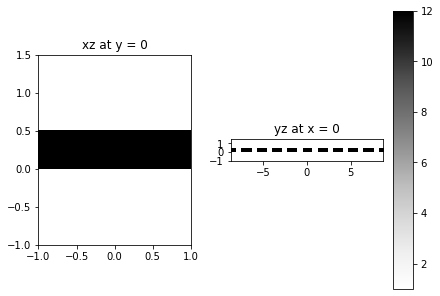

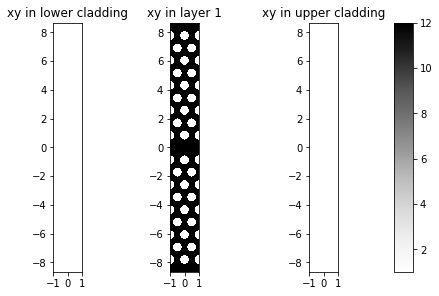

In [2]:
# Number of PhC periods in vertical direction
Ny = 10
# Radius of circle holes
ra = 0.3
# Initialize a lattice
lattice = Lattice([1., 0], [0, Ny*np.sqrt(3)/2])
# Initialize a PhC (by default with eps = 1 in upper and lower cladding, we set upper one to 5)
phc = PhotCryst(lattice)
# Add a layer to the PhC with thickness 1 and background permittivity 10
phc.add_layer(d=0.5, eps_b=12.)
# Add a shape to this layer 
for ih in range(Ny):
    if ih != Ny//2:
        circ = Circle(x_cent=(ih%2)*0.5, y_cent = (-Ny//2 + ih)*np.sqrt(3)/2, r=ra)
        phc.layers[-1].add_shape(circ)
# Plot an overview picture
phc.plot_overview(cladding='True', Ny=500)

## Define and run the guided mode expansion

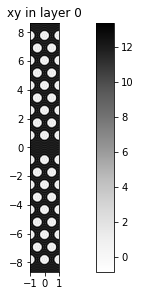

In [3]:
gme = GuidedModeExp(phc, gmax=3)
gme.plot_overview_ft(Ny=500)

In [4]:
path = phc.lattice.bz_path(['G', np.array([np.pi, 0])], [50])

In [5]:
gme.run(kpoints=path.kpoints, gmode_inds=[0], verbose=False, numeig=20)

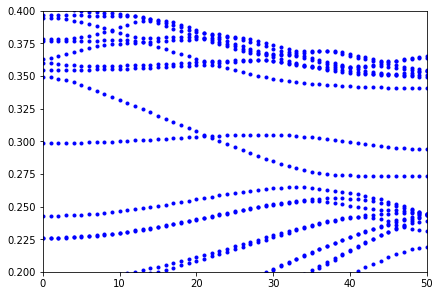

In [6]:
# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(gme.freqs, '.b')
ax.set_ylim([0.2, 0.4])
ax.set_xlim([0, gme.freqs.shape[0]-1])
plt.show()

In [8]:
xcs = [(ih%2)*0.5 for ih in range(Ny)]
ycs = [(-Ny//2 + ih)*np.sqrt(3)/2 for ih in range(Ny)]

In [9]:
# Define a waveguide with "moved" holes
def gme_w1(xm, ym):
    phc = PhotCryst(lattice)
    phc.add_layer(d=0.5, eps_b=12.)
    for ih in range(Ny):
        if ih != Ny//2:
            xc = xcs[ih]
            yc = ycs[ih]
            if np.abs(-Ny//2 + ih) < xm.size + 0.5:
                xc += xm[np.abs(-Ny//2 + ih)-1]
                yc += ym[np.abs(-Ny//2 + ih)-1]*np.sign((-Ny//2 + ih))
            circ = Circle(x_cent=xc, y_cent=yc, r=ra)
            phc.layers[-1].add_shape(circ)
    gme = GuidedModeExp(phc, gmax=3)
    return gme

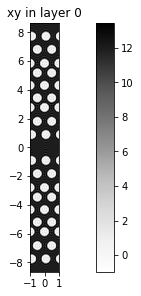

In [10]:
gme_test = gme_w1(np.array([0.1, 0, 0]), np.array([0.05, 0.1, 0.2]))
gme_test.plot_overview_ft(Ny=500)

In [11]:
import autograd.numpy as npa
from autograd import grad
pygme.set_backend('autograd')

In [12]:
# Define an objective function
# It's somewhat random, but let's try to make the dispersion in the end of the guided band as flat as possible
def of_w1(params):
    xm = params[0:3]
    ym = params[3:6]
    # Initialize the GME
    gme = gme_w1(xm, ym)

    # Run the GME
    gme.run(kpoints=path.kpoints, gmode_inds=[0], verbose=False, numeig=20)
    # These is not exactly the guided band but should be correct for the region right around the band edge at X
    freqs_wg = gme.freqs[:, Ny]

    return npa.sqrt(npa.var(freqs_wg[-20:]))

print(of_w1(np.zeros((6,))))

0.0027778583196951217


In [13]:
# Let's first test the gradient
from pygme.utils import grad_num
grad_test = grad(of_w1)

print('Autograd gradient:  ', grad_test(np.zeros((6,))))
print('Numerical gradient: ', grad_num(of_w1, np.zeros((6,))))

Autograd gradient:   [ 3.03576608e-18  4.33680869e-18  4.33680869e-19 -1.13084807e-03
  1.05337502e-02  3.91616273e-04]
Numerical gradient:  [-5.20417043e-10 -1.80411242e-09 -2.51534904e-10 -1.13085129e-03
  1.05337519e-02  3.91616756e-04]


In [14]:
from pygme.optimizers import adam_optimize

In [15]:
p_start = np.zeros((6,))

In [16]:
# Run the optimization
(p_opt, ofs) = adam_optimize(of_w1, p_start, grad_test, step_size = 1e-2, Nsteps = 10, 
                             options = {'direction': 'min', 'disp': ['of', 'params']})

At iteration 0 :
Objective value is:   0.0027778583196951217
Parameters are:       [ 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000]
At iteration 1 :
Objective value is:   0.0026507319020277853
Parameters are:       [-0.0000 -0.0000 -0.0000  0.0100 -0.0100 -0.0100]
At iteration 2 :
Objective value is:   0.0025097855630498178
Parameters are:       [-0.0000 -0.0000 -0.0000  0.0197 -0.0200 -0.0200]
At iteration 3 :
Objective value is:   0.002352935703721811
Parameters are:       [-0.0014  0.0008  0.0007  0.0293 -0.0300 -0.0300]
At iteration 4 :
Objective value is:   0.0021710976039514486
Parameters are:       [-0.0072  0.0067  0.0065  0.0389 -0.0401 -0.0401]
At iteration 5 :
Objective value is:   0.0019541111390808663
Parameters are:       [-0.0133  0.0128  0.0126  0.0486 -0.0501 -0.0502]
At iteration 6 :
Objective value is:   0.0016875398673256708
Parameters are:       [-0.0203  0.0197  0.0195  0.0583 -0.0602 -0.0603]
At iteration 7 :
Objective value is:   0.001357072847037003
Parameters

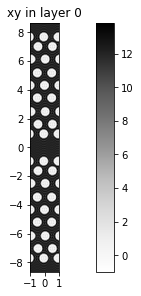

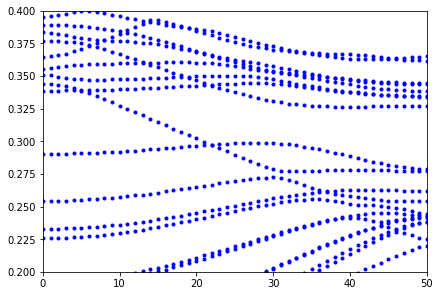

In [19]:
gme_test = gme_w1(np.array(p_opt[0:3]), np.array(p_opt[3:6]))
gme_test.plot_overview_ft(Ny=500)
gme_test.run(kpoints=path.kpoints, gmode_inds=[0], verbose=False, numeig=20)

fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(gme_test.freqs, '.b')
ax.set_ylim([0.2, 0.4])
ax.set_xlim([0, gme.freqs.shape[0]-1])
plt.show()

## Well it worked! 
Although, this might not be exactly what we want, because the guided band now looks mixed with the valence bands.
As usual, the problem is with writing a good objective function and constraining your parameters well.
But apart from that, **I'll be damned, it worked!**

## Radius as free parameter

In [20]:
# Define a waveguide with holes with changed size
def gme_r(rm):
    phc = PhotCryst(lattice)
    phc.add_layer(d=0.5, eps_b=12.)
    for ih in range(Ny):
        if ih != Ny//2:
            xc = xcs[ih]
            yc = ycs[ih]
            rc = ra
            if np.abs(-Ny//2 + ih) < rm.size + 0.5:
                rc += rm[np.abs(-Ny//2 + ih)-1]
            circ = Circle(x_cent=xc, y_cent=yc, r=rc)
            phc.layers[-1].add_shape(circ)
    gme = GuidedModeExp(phc, gmax=3)
    return gme

# Define an objective function
# It's somewhat random, but let's try to make the dispersion in the end of the guided band as flat as possible
def of_w1(params):
    # Initialize the GME
    gme = gme_r(params)

    # Run the GME
    gme.run(kpoints=path.kpoints, gmode_inds=[0], verbose=False, numeig=20)
    # These is not exactly the guided band but should be correct for the region right around the band edge at X
    freqs_wg = gme.freqs[:, Ny]

    return npa.sqrt(npa.var(freqs_wg[-20:]))

print(of_w1(np.zeros((4,))))

0.0027778583196951217


In [21]:
# test the gradient
grad_test = grad(of_w1)

print('Autograd gradient:  ', grad_test(np.zeros((4,))))
print('Numerical gradient: ', grad_num(of_w1, np.zeros((4,))))

Autograd gradient:   [-0.0118 -0.0192 -0.0023 -0.0015]
Numerical gradient:  [-0.0101 -0.0176 -0.0006  0.0002]


In [22]:
p_start = np.zeros((4,))
# Run the optimization
(p_opt, ofs) = adam_optimize(of_w1, p_start, grad_test, step_size = 1e-2, Nsteps = 10, 
                             options = {'direction': 'min', 'disp': ['of', 'params']})

At iteration 0 :
Objective value is:   0.0027778583196951217
Parameters are:       [ 0.0000  0.0000  0.0000  0.0000]
At iteration 1 :
Objective value is:   0.0024886239618996248
Parameters are:       [ 0.0100  0.0100  0.0100  0.0100]
At iteration 2 :
Objective value is:   0.002182924433059464
Parameters are:       [ 0.0200  0.0200  0.0200  0.0200]
At iteration 3 :
Objective value is:   0.0018597635060162514
Parameters are:       [ 0.0300  0.0300  0.0299  0.0299]
At iteration 4 :
Objective value is:   0.0015190366662164129
Parameters are:       [ 0.0401  0.0400  0.0398  0.0397]
At iteration 5 :
Objective value is:   0.0011626633001213477
Parameters are:       [ 0.0502  0.0499  0.0497  0.0494]
At iteration 6 :
Objective value is:   0.0007970949662411595
Parameters are:       [ 0.0604  0.0599  0.0595  0.0587]
At iteration 7 :
Objective value is:   0.0004400506351972825
Parameters are:       [ 0.0706  0.0698  0.0694  0.0677]
At iteration 8 :
Objective value is:   0.00015657027131946695
Par

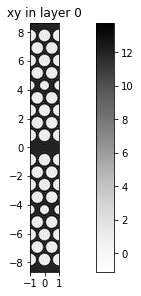

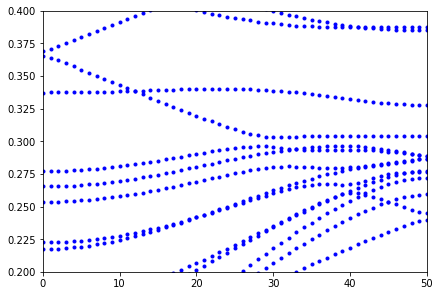

In [23]:
gme_test = gme_r(p_opt)
gme_test.plot_overview_ft(Ny=500)
gme_test.run(kpoints=path.kpoints, gmode_inds=[0], numeig=20, verbose=False)

fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(gme_test.freqs, '.b')
ax.set_ylim([0.2, 0.4])
ax.set_xlim([0, gme.freqs.shape[0]-1])
plt.show()